original length of file: 194763 
training accuracy 0.98
testing accuracy 0.92
             precision    recall  f1-score   support

        0.0       0.93      0.98      0.96     29733
        1.0       0.80      0.53      0.64      4351

avg / total       0.92      0.92      0.92     34084



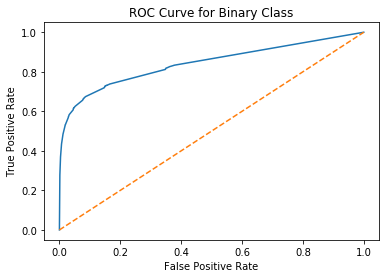

cross validation [ 0.92760745  0.92709403  0.92775414  0.92826757  0.92592049  0.92488814
  0.92327441  0.92855571  0.92694198  0.92877054]
             precision    recall  f1-score   support

        0.0       0.94      0.98      0.96     51038
        1.0       0.78      0.53      0.63      7391

avg / total       0.92      0.92      0.92     58429



In [5]:
##### multiclass.py from SF-Fire-Risk project
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import pandas as pd
import numpy as np

def XY_data(multiclass=False):
    #will process binary or multiclass

    k=pd.read_csv('data/molly_master_11152017.csv',low_memory=False)
    # set target to Fire Incident Type
    y=k.pop('Incident_Dummy')
    
    x=k
    #calculate property age
    x['age_of_building']=2016-x.Yr_Property_Built
    
    print('original length of file: %i ' % len(y))

    return x, y 

def Data_normalized(multiclass=False):

    x,y = XY_data()

    x_quant = x[['Yr_Property_Built',
           'Num_Stories', 'Num_Units', 'Perc_Ownership', 'Land_Value',
           'Property_Area', 'Assessed_Improvement_Val', 'Tot_Rooms',
           'landval_psqft', 'count_potential_fire_control', 'count_all_complaints',
           'population', 'median_age', 'avg_household_size',
           'num_housing_units', 'seasonal',
           'num_under_18', 'total_hholds', 'gini_a', 'gini_b']].copy()

    x_quant['pct_vacant'] = np.where(x.num_housing_units!=0, x.vacant / x.num_housing_units, 0)

    x_quant['pub_assist_income'] = np.where(x.total_hholds!=0, x.hholds_pubassist / x.total_hholds, 0)

    x_quant['children'] = np.where(x.population!=0, x.num_under_18 / x.population, 0)

    # and categorical features:

    x_dummies = pd.get_dummies(data=x[['Neighborhood']])


    #normalize quantitative features
    # x_scaled=(x_quantitative-x_quantitative.mean())/(x_quantitative.max()-x_quantitative.min())
    # i'll try ^ this first .. but then go back and normalize by population

    # x_dummies['Neighborhood'] = x_dummies['Neighborhood'].apply(lambda x: x.cat.codes)
    

    #combine x dummies and x scaled data
    x_all=pd.concat([x_quant, x_dummies],axis=1)
    
    # separate a global test set to test model after training it
    X, testx, Y, testy = train_test_split(x_all, y, test_size=.30, random_state=415)
    
    return X, testx, Y, testy  #,unique


def classifier(train=True,x=None,y=None,class_weight=None,multiclass=False,plot=False,cross_val=False):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.multiclass import OneVsRestClassifier

    # use multiclass random forest classifier for both binary and multiclass
    if multiclass:

        rf_model=OneVsRestClassifier(RandomForestClassifier(verbose=0,class_weight=class_weight),
                                                             n_jobs=3, random_state=415)
    else:
        rf_model = RandomForestClassifier(verbose=0, class_weight=class_weight, random_state=415)

    xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=.25, random_state=415)

    import pickle
    train=train

    if train: # run training and pickle model else just load model
        
        # lots more 0's than 1's so let's give sample weights
        smpl_wghts = np.array([8 if i == 0 else 1 for i in ytrain])
        
        rf_model.fit(xtrain,ytrain, sample_weight=smpl_wghts)
        # output file name
        output=open('clf.pkl','wb')
        s = pickle.dump(rf_model,output)
    # load output file
    # load=open('clf.pkl','rb')
    # return model
    # rf_model = pickle.load(load)

    print('training accuracy {:.2f}'.format(rf_model.score(xtrain,ytrain)))

    print('testing accuracy {:.2f}'.format(rf_model.score(xtest,ytest)))

    ypred=rf_model.predict(xtest)
    ypred=pd.DataFrame(ypred)

    #print('labels {}'.format(target_names))
    ytest=ytest.reset_index(drop=True)

    print(classification_report(ytest,ypred))
    #print(multiclass)

    

    if multiclass == False:
        from sklearn.metrics import roc_curve

        fpr, tpr, thresh=roc_curve(ytest,rf_model.predict_proba(xtest)[:,1])

        import matplotlib.pyplot as plt
        plt.plot(fpr,tpr,linestyle='-')
        plt.plot([0,1],[0,1],linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Binary Class')
        if plot:
            plt.show()
            
    #print([xtrain.columns[i] for i in np.argsort(rf_model.feature_importances_)[::-10]])

    
    from sklearn.model_selection import cross_val_score
    if cross_val:
        scores=cross_val_score(rf_model,X=x,y=y,cv=10)
        print('cross validation {}'.format(scores))
        
    # tune hyper parameters
    
        
    return rf_model


if __name__ == '__main__':

    x, testx, y, testy = Data_normalized(multiclass=False)
    #
    #classifier(train=True,x=x,y=y,target_names=target_names, class_weight=None,multiclass=False,plot=False,cross_val=True)
    # weights = np.array([8 if i == 0 else 1 for i in ytrain])
    
    rfmod = classifier(train=True,x=x,y=y, multiclass=False,plot=True,cross_val=True)
    
    testpreds=rfmod.predict(testx)
    testpreds=pd.DataFrame(testpreds).reset_index(drop=True)

    print(classification_report(testy,testpreds))
    
    #feat_imp = dict(rfmod.feature_importances_)
    
    #[print("%s:" % (ft)) for ft in feat_imp]
    #print(feat_imp.dtype)
    

In [6]:
k = pd.read_csv("data/molly_master_11152017.csv")

[print(col) for col in k.columns]

k = k

Unnamed: 0
EAS
Incident_Dummy
Yr_Property_Built
Num_Stories
Num_Units
Perc_Ownership
Land_Value
Property_Area
Assessed_Improvement_Val
Tot_Rooms
landval_psqft
count_potential_fire_control
count_all_complaints
tract
census_block
latlong
inde
county
blkgroup
rur_urb
zip
population
median_age
avg_household_size
num_housing_units
occupied
vacant
seasonal
Neighborhood
num_under_18
total_hholds
hholds_pubassist
hholds_no_pubassist
gini_a
gini_b


In [3]:
from column_report import get_column_report

get_column_report(x)

ModuleNotFoundError: No module named 'column_report'